In [ ]:
!apt-get install xvfb -y
!pip install pyvirtualdisplay
!pip install Pillow
!pip install "gym[box2d]"

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
import gym
import time
import tqdm
import numpy as np
from IPython import display
from PIL import Image

In [ ]:
class RandomAgent:
    def __init__(self, env_name: str):
        self.env = gym.make(env_name)
        self.action_count = self.env.action_space.n

    def choose_action(self, state):
        return np.random.randint(self.action_count)

    def simulate(self, visualize=True):
        records = []
        state = self.env.reset()
        is_done = False
        total_score = 0

        while not is_done:
            action = self.choose_action(state)
            # 执行动作
            observation, reward, is_done, info = self.env.step(action)
            # 记录总分
            total_score += reward
            
            # 渲染画面，得到画面的像素数组
            rgb_array = self.env.render(mode='rgb_array')
            # 记录中间过程，用于后期可视化
            records.append((rgb_array, action, reward, total_score))

            if visualize:
                # 清除当前 Cell 的输出
                display.clear_output(wait=True)
                                
                # 使用像素数组生成图片
                img = Image.fromarray(rgb_array)
                # 当前 Cell 中展示图片
                display.display(img)
                print(f'Action {action} Action reward {reward:.2f} | Total score {total_score:.2f}')
                # 防止刷新过快，可以根据实际情况调小
                time.sleep(0.01)
        self.env.close()
        return total_score, records

In [ ]:
agent = RandomAgent('LunarLander-v2')

In [ ]:
total_score, records = agent.simulate(visualize=True)
print(f'Total score {total_score:.2f}')

In [ ]:
record_list = []
for i in tqdm.tqdm(range(100)):
    total_score, _ = agent.simulate(visualize=False)
    record_list.append(total_score)
    
print(f'Average score in 100 episode {np.mean(record_list):.2f}')

In [ ]:
import random
import numpy as np
from collections import namedtuple

# 代表每一个样本的 namedtuple，方便存储和读取数据
Experience = namedtuple('Experience', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory:

    def __init__(self, max_size):
        self.max_size = max_size
        self.memory = []

    def append(self, state, action, reward, next_state, done):
        """记录一个新的样本"""
        sample = Experience(state, action, reward, next_state, done)
        self.memory.append(sample)
        # 只留下最新记录的 self.max_size 个样本
        self.memory = self.memory[-self.max_size:]

    def sample(self, batch_size):
        """按照给定批次大小取样"""
        samples = random.sample(self.memory, batch_size)
        batch = Experience(*zip(*samples))

        # 转换数据为 numpy 张量返回
        states = np.array(batch.state)
        actions = np.array(batch.action)
        rewards = np.array(batch.reward)
        states_next = np.array(batch.next_state)
        dones = np.array(batch.done)

        return states, actions, rewards, states_next, dones

    def __len__(self):
        return len(self.memory)

In [ ]:
import tensorflow as tf

L = tf.keras.layers


def create_network_model(input_shape: np.ndarray,
                         action_space: np.ndarray,
                         learning_rate=0.001) -> tf.keras.Sequential:
    model = tf.keras.Sequential([
        L.Dense(512, input_shape=input_shape, activation="relu"),
        L.Dense(256, input_shape=input_shape, activation="relu"),
        L.Dense(action_space)
    ])
    model.compile(loss="mse", 
                  optimizer=tf.optimizers.Adam(lr=learning_rate))
    return model

In [ ]:
from IPython import display
from PIL import Image

# 定义超参数
LEARNING_RATE = 0.001
GAMMA = 0.99
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.01


class DQNAgent:
    def __init__(self, env_name):
        self.env = gym.make(env_name)
        self.observation_shape = self.env.observation_space.shape
        self.action_count = self.env.action_space.n
        self.model = create_network_model(self.observation_shape, self.action_count)
        self.memory = ReplayMemory(500000)
        self.epsilon = 1.0
        self.batch_size = 64

    def choose_action(self, state, epsilon=None):
        """
        根据给定状态选择行为
        - epsilon == 0 完全使用模型选择行为
        - epsilon == 1 完全随机选择行为
        """
        if epsilon is None:
            epsilon = self.epsilon
        if np.random.rand() < epsilon:
            return np.random.randint(self.action_count)
        else:
            q_values = self.model.predict(np.expand_dims(state, axis=0))
            return np.argmax(q_values[0])

    def replay(self):
        """进行经验回放学习"""

        # 如果当前经验池经验数量少于批次大小，则跳过
        if len(self.memory) < self.batch_size:
            return

        states, actions, rewards, states_next, dones = self.memory.sample(self.batch_size)
        q_pred = self.model.predict(states)

        q_next = self.model.predict(states_next).max(axis=1)
        q_next = q_next * (1 - dones)
        q_update = rewards + GAMMA * q_next

        indices = np.arange(self.batch_size)
        q_pred[[indices], [actions]] = q_update

        self.model.train_on_batch(states, q_pred)

    def simulate(self, epsilon=None, visualize=True):
        records = []
        state = self.env.reset()
        is_done = False
        total_score = 0
        total_step  = 0
        while not is_done:
            action = self.choose_action(state, epsilon)
            state, reward, is_done, info = self.env.step(action)
            total_score += reward
            total_step += 1
            
            rgb_array = self.env.render(mode='rgb_array')
            records.append((rgb_array, action, reward, total_score))

            if visualize:
                display.clear_output(wait=True)
                img = Image.fromarray(rgb_array)
                # 当前 Cell 中展示图片
                display.display(img)
                print(f'Action {action} Action reward {reward:.2f} | Total score {total_score:.2f} | Step {total_step}')

                time.sleep(0.01)
        self.env.close()
        return total_score, records

    def train(self, episode_count: int, log_dir: str):
        """
        训练方法，按照给定 episode 数量进行训练，并记录训练过程关键参数到 TensorBoard
        """
        # 初始化一个 TensorBoard 记录器
        file_writer = tf.summary.create_file_writer(log_dir)
        file_writer.set_as_default()

        score_list = []
        best_avg_score = -np.inf

        for episode_index in range(episode_count):
            state = self.env.reset()
            score, step = 0, 0
            is_done = False
            while not is_done:
                # 根据状态选择一个行为
                action = self.choose_action(state)
                # 执行行为，记录行为和结果到经验池
                state_next, reward, is_done, info = self.env.step(action)
                self.memory.append(state, action, reward, state_next, is_done)
                score += reward

                state = state_next
                # 每 6 步进行一次回放训练
                # 此处也可以选择每一步回放训练，但会降低训练速度，这个是一个经验技巧
                if step % 1 == 0:
                    self.replay()
                step += 1

            # 记录当前 Episode 的得分，计算最后 100 Episode 的平均得分
            score_list.append(score)
            avg_score = np.mean(score_list[-100:])

            # 记录当前 Episode 得分，epsilon 和最后 100 Episode 的平均得分到 TensorBoard
            tf.summary.scalar('score', data=score, step=episode_index)
            tf.summary.scalar('average score', data=avg_score, step=episode_index)
            tf.summary.scalar('epsilon', data=self.epsilon, step=episode_index)

            # 终端输出训练进度
            print(f'Episode: {episode_index} Reward: {score:03.2f} '
                  f'Average Reward: {avg_score:03.2f} Epsilon: {self.epsilon:.3f}')

            # 调整 epsilon 值，逐渐减少随机探索比例
            if self.epsilon > EPSILON_MIN:
                self.epsilon *= EPSILON_DECAY

            # 如果当前平均得分比之前有改善，保存模型
            # 确保提前创建目录 outputs/chapter_15
            if avg_score > best_avg_score:
                best_avg_score = avg_score
                self.model.save(f'outputs/chapter_15/dqn_best_{episode_index}.h5')

In [ ]:
# 使用 LunarLander 初始化 Agent
agent = DQNAgent('LunarLander-v2')

In [ ]:
import glob
# 读取现在已经记录的日志数量，避免日志重复记录
tf_log_index = len(glob.glob('tf_dir/lunar_lander/run_*'))
log_dir = f'tf_dir/lunar_lander/run_{tf_log_index}'

# 训练 2000 个 Episode
agent.train(2000, log_dir)

In [11]:
# agent.model.load_weights('dqn_best.h5')
agent.model.load_weights('dqn_best.h5')

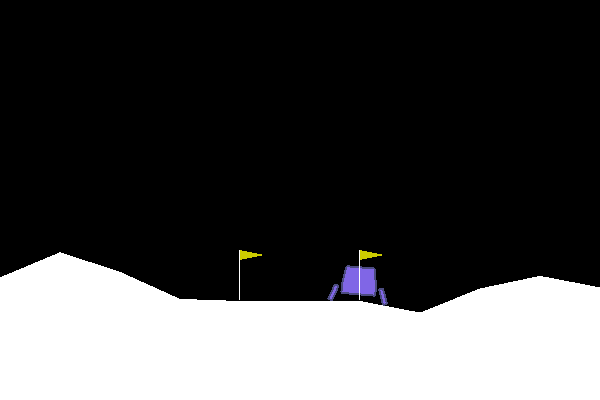

Action 0 Action reward 100.00 | Total score 245.31 | Step 341


In [14]:
score, records = agent.simulate(epsilon=0.0, visualize=True)

In [ ]:
!cp outputs/chapter_15/dqn_best.h5 dqn_best.h5 